In [1]:
import numpy as np
import pandas as pd
import requests # urllib 말고 requests 써주세요 (urllib은 구식입니다!)
from bs4 import BeautifulSoup as bs
import lxml
from selenium import webdriver # 자바스크립트로 전송 되는 데이터는 url - html에 안붙어있습니다.. 페이지를 열어줘야 데이터가 와요!
import time
import requests
from selenium.webdriver.common.keys import Keys

In [2]:
path = r"C:\Users\monde\Documents\고경\GH\Session 4\chromedriver.exe" # 각자의 경로에 맞게 설정하면 됩니다. 

driver = webdriver.Chrome(path)

# 기다려줍시다
driver.implicitly_wait(3) #혹은 time.sleep(3)

# Quest

aqi사이트:https://aqicn.org/city/korea/seoul/gwanak-gu/

위의 사이트에서 각자 좋아하는 관악구의 pm25와 pm10의 월별 aqi 시계열도를 그리고 최적의 sarima 모델을 찾아라!

trainset = 처음 데이터 ~ 최근 6개월 데이터

testset = 최근 6개월 데이터

hint:

- groupby를 쓰면 월별 지표를 구하기 쉽습니다.
- 결측치를 처리할 방법을 생각해 보세요!
- 예측값이 좋지 않다면 예측 설명을 해주실수 있으면 좋습니다! (ex 코로나..)

In [3]:
driver.get("https://aqicn.org/city/korea/seoul/gwanak-gu/")

# 여기서 주의할점이 스크롤을 내려야 데이터가 뽑히는데 그냥 드라이버 내에서 스크롤 내려도 되고
# 스크롤 함수를 써도 됩니다!!
# 저는 그냥 내려서 데이터 업데이트 된거 보고 뽑았어요

driver.implicitly_wait(3)

In [4]:
#pm25 데이터 (pm25 화면 불러오기)
aqi_html = driver.page_source
print(aqi_html)
parsed_html = bs(aqi_html, 'lxml')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
#pm10 데이터 (pm10 화면 불러오기)
aqi_html2 = driver.page_source
print(aqi_html2)
parsed_html2 = bs(aqi_html2, 'lxml')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
#testset의 월데이터
test_month = ["20200"+str(i) for i in range(3,9)]

In [7]:
#trainset의 월데이터

month_14 = ["20140"+str(i) for i in range(7,10)] + ["2014"+str(i) for i in range(10,12)]
month_15 = ["20150"+str(i) for i in range(10)] + ["2015"+str(i) for i in range(10,12)]
month_16 = ["20160"+str(i) for i in range(10)] + ["2016"+str(i) for i in range(10,12)]
month_17 = ["20170"+str(i) for i in range(10)] + ["2017"+str(i) for i in range(10,12)]
month_18 = ["20180"+str(i) for i in range(10)] + ["2018"+str(i) for i in range(10,12)]
month_19 = ["20190"+str(i) for i in range(10)] + ["2019"+str(i) for i in range(10,12)]
month_20 = ["20200"+str(i) for i in range(3)]

train_month = month_14+month_15+month_16+month_17+month_18+month_19+month_20

In [8]:
#전체 월데이터
month = train_month + test_month

In [9]:
#전체 pm25 데이터

pm_25 = parsed_html.find("tr", {"key":"201407"}).find("td",{"class","squares"})
df_25 = pd.Series(pm_25.get_text(" ").split(), index = pd.date_range(start='08/01/2014', end='09/01/2014')[:-1])

for mo in month[1:]:
    pm_25 = parsed_html.find("tr", {"key":mo}).find("td",{"class","squares"})
    if mo[-2:] == '11':
        df_25 = pd.concat([df_25, pd.Series(pm_25.get_text(" ").split(), 
                                            index = pd.date_range(start='12/01/'+str(int(mo[:-2])), 
                                                                  end='12/31/'+str(int(mo[:-2]))))])
    else: 
        df_25 = pd.concat([df_25, pd.Series(pm_25.get_text(" ").split(),
                                              index = pd.date_range(start=str(int(mo[-2:])+1)+'/01/'+str(int(mo[:-2])),
                                                                    end=str(int(mo[-2:])+2)+'/01/'+str(int(mo[:-2])))[:-1])])

In [10]:
df_25

2014-08-01     -
2014-08-02     -
2014-08-03    43
2014-08-04    32
2014-08-05    29
              ..
2020-09-26     -
2020-09-27     -
2020-09-28     -
2020-09-29     -
2020-09-30     -
Freq: D, Length: 2253, dtype: object

In [11]:
#전체 pm10 데이터

pm_10 = parsed_html2.find("tr", {"key":"201407"}).find("td",{"class","squares"})
df_10 = pd.Series(pm_10.get_text(" ").split(), index = pd.date_range(start='08/01/2014', end='09/01/2014')[:-1])

for mo in month[1:]:
    pm_10 = parsed_html2.find("tr", {"key":mo}).find("td",{"class","squares"})
    if mo[-2:] == '11':
        df_10 = pd.concat([df_10, pd.Series(pm_10.get_text(" ").split(), 
                                            index = pd.date_range(start='12/01/'+str(int(mo[:-2])), 
                                                                  end='12/31/'+str(int(mo[:-2]))))])
    else: 
        df_10 = pd.concat([df_10, pd.Series(pm_10.get_text(" ").split(),
                                              index = pd.date_range(start=str(int(mo[-2:])+1)+'/01/'+str(int(mo[:-2])),
                                                                    end=str(int(mo[-2:])+2)+'/01/'+str(int(mo[:-2])))[:-1])])

In [12]:
df_10

2014-08-01    31
2014-08-02    18
2014-08-03    16
2014-08-04    15
2014-08-05    12
              ..
2020-09-26     -
2020-09-27     -
2020-09-28     -
2020-09-29     -
2020-09-30     -
Freq: D, Length: 2253, dtype: object

In [13]:
df_25[df_25 == '-'].count()

111

In [14]:
df_10[df_10 == '-'].count()

108

In [15]:
#결측치 삭제&float로 변환
df_25[df_25 == "-"] = np.nan
df_25 = df_25.dropna()
df_25 = df_25.astype(float)

df_10[df_10 == "-"] = np.nan
df_10 = df_10.dropna()
df_10 = df_10.astype(float)

### 시각화

In [16]:
import matplotlib.pyplot as plt

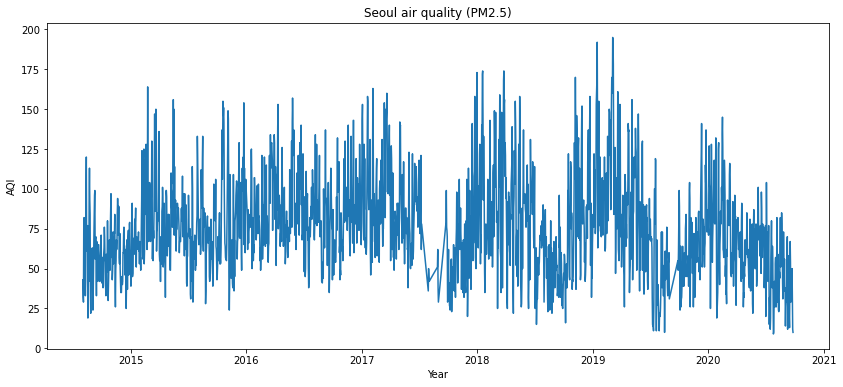

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
plt.plot(df_25)
plt.title("Seoul air quality (PM2.5)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()

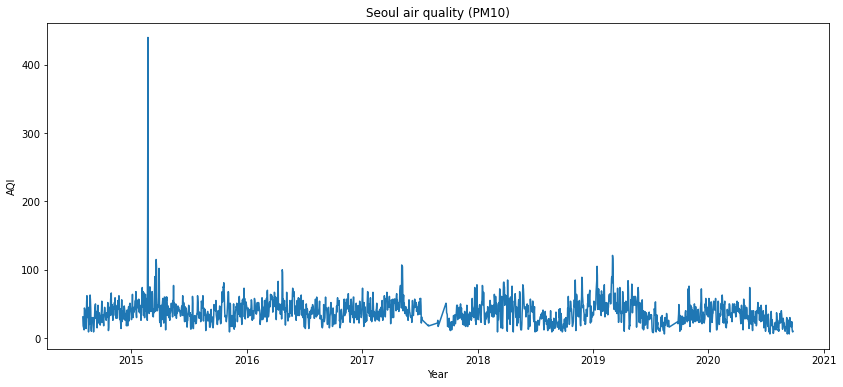

In [18]:
rcParams['figure.figsize'] = 14, 6
plt.plot(df_10)
plt.title("Seoul air quality (PM10)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()

#PM10 데이터에는 outlier가 존재한다.

In [19]:
#월별 데이터는 평균으로
df_25_month = df_25.to_frame()
df_25_month['Month'] = df_25_month.index.astype(str).str[:7]
df_25_month = df_25_month.groupby(by='Month').mean()
df_25_month = df_25_month.rename(columns={0: 'AQI'})
df_25_month = df_25_month.reset_index()

df_10_month = df_10.to_frame()
df_10_month['Month'] = df_10_month.index.astype(str).str[:7]
df_10_month = df_10_month.groupby(by='Month').mean()
df_10_month = df_10_month.rename(columns={0: 'AQI'})
df_10_month = df_10_month.reset_index()

In [20]:
print(df_25_month)
print(df_10_month)

      Month        AQI
0   2014-08  59.655172
1   2014-09  59.100000
2   2014-10  56.225806
3   2014-11  64.000000
4   2014-12  53.620690
..      ...        ...
69  2020-05  57.870968
70  2020-06  67.766667
71  2020-07  44.741935
72  2020-08  50.935484
73  2020-09  36.880000

[74 rows x 2 columns]
      Month        AQI
0   2014-08  30.903226
1   2014-09  31.200000
2   2014-10  34.903226
3   2014-11  40.133333
4   2014-12  34.607143
..      ...        ...
69  2020-05  30.354839
70  2020-06  33.100000
71  2020-07  20.548387
72  2020-08  22.000000
73  2020-09  18.480000

[74 rows x 2 columns]


In [21]:
df_25_month["Month"] = pd.to_datetime(df_25_month["Month"])
y1=df_25_month.set_index("Month")

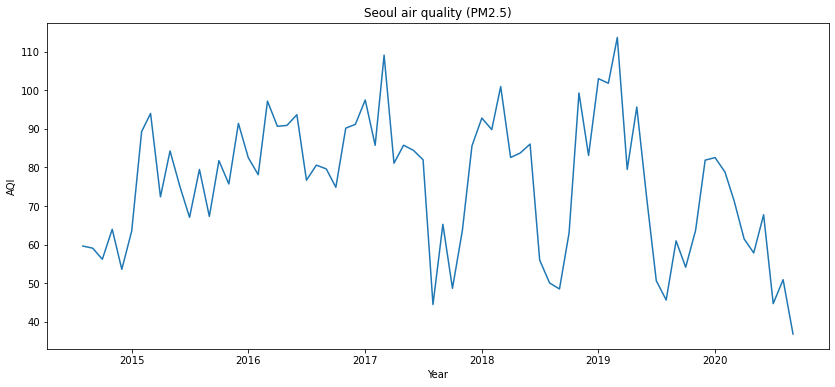

In [22]:
rcParams['figure.figsize'] = 14, 6
plt.plot(y1)
plt.title("Seoul air quality (PM2.5)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()

In [23]:
df_10_month["Month"] = pd.to_datetime(df_10_month["Month"])
y2 = df_10_month.set_index("Month")

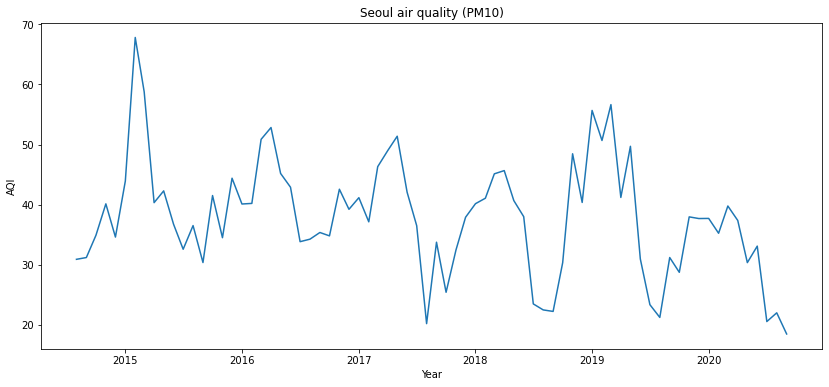

In [24]:
rcParams['figure.figsize'] = 14, 6
plt.plot(y2)
plt.title("Seoul air quality (PM10)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()

## 시계열 분석

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels
from sklearn.metrics import mean_squared_error

import warnings
import itertools
warnings.filterwarnings("ignore")

### PM2.5 분석

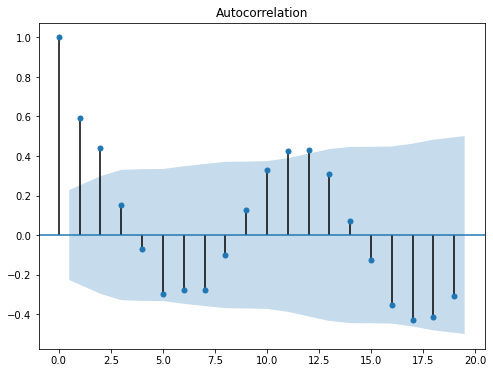

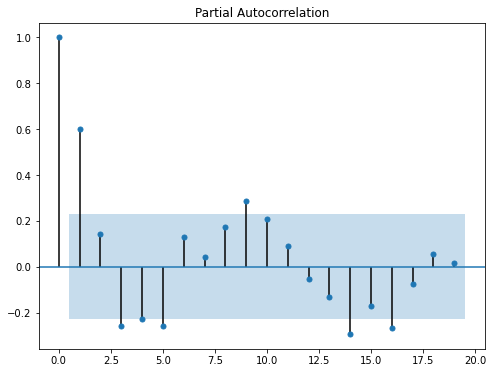

In [26]:
# acf
rcParams['figure.figsize'] = 8, 6
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_acf(y1)
fig = plot_pacf(y1)

In [27]:
# adfuller test - 단위근검정
result = sm.tsa.stattools.adfuller(y1, maxlag = 1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#p-value = 0.003308 으로 귀무가설을 기각한다!

ADF Statistic: -3.763108
p-value: 0.003308
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588


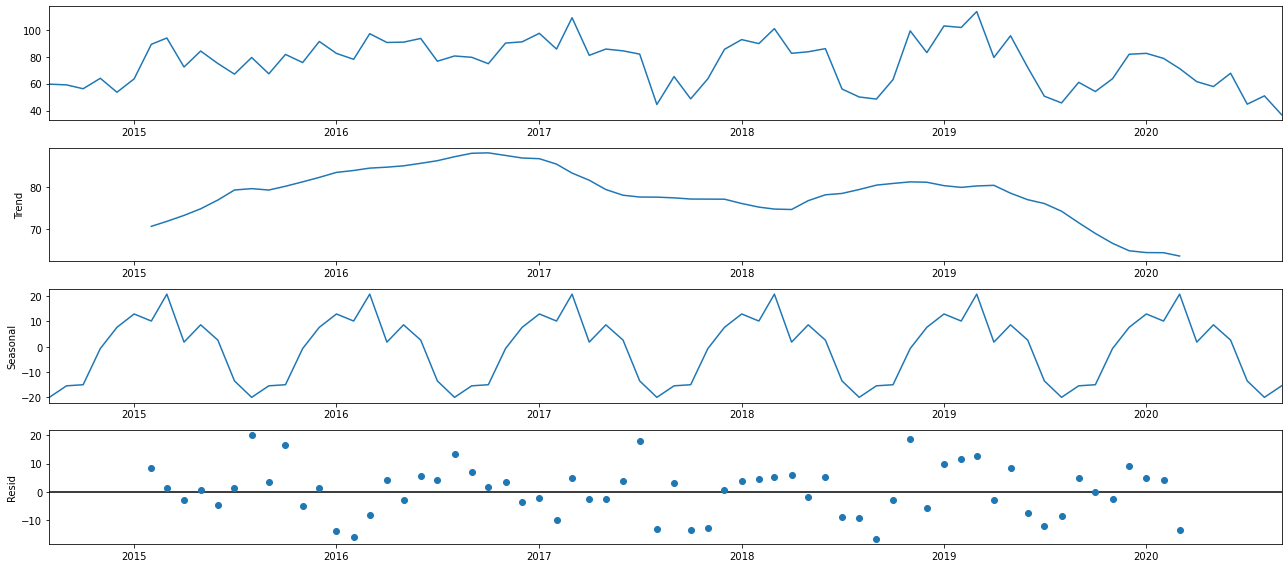

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, model='additive')
fig = decomposition.plot()
plt.show()

#주기성을 보인다.

In [30]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [33]:
aic_result=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y1,
                                            order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            aic_result.append(results.aic)
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:845.0282904696412
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:657.7087362343807
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:520.8086692006528
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:410.474292093622
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:529.8160919822361
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:512.187706099065
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:418.43414073451436
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:410.47048758248076
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:763.0872247063065
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:609.3297629871677
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:510.08451132719927
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:397.2501047361752
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:526.4191347930451
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:497.19055305717785
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:412.57325262856443
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:396.70763061682453
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:595.1464871241074
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:498.7431621425046
ARIMA(

In [34]:
min(aic_result)

380.5608760216347

In [46]:
#최적의 값으로 fitting: ARIMA(0, 1, 1)x(1, 1, 1, 12)12

mod = sm.tsa.statespace.SARIMAX(y1,  
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5819      0.173     -3.360      0.001      -0.921      -0.242
ar.S.L12      -0.0177      0.020     -0.886      0.376      -0.057       0.021
ma.S.L12      -1.0000      0.197     -5.080      0.000      -1.386      -0.614
sigma2       117.0904      0.002   6.96e+04      0.000     117.087     117.094


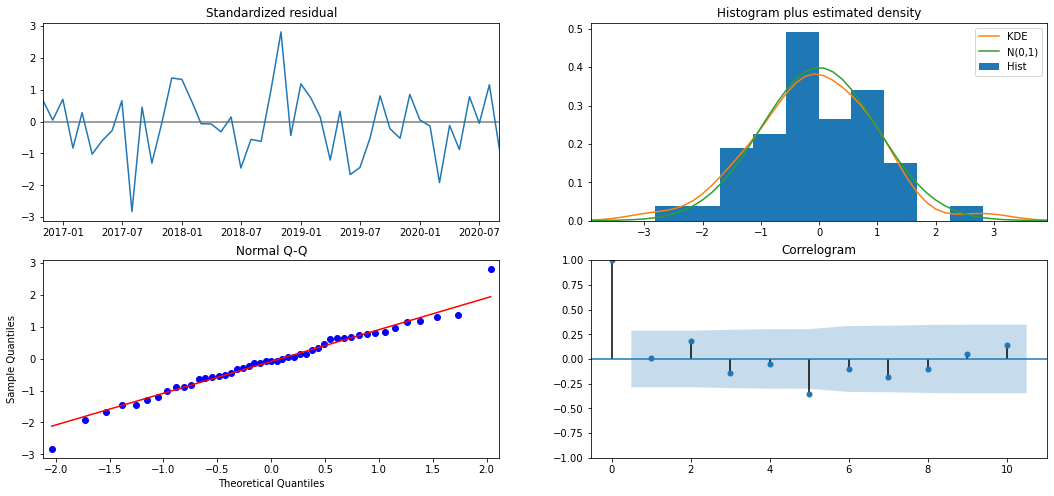

In [47]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

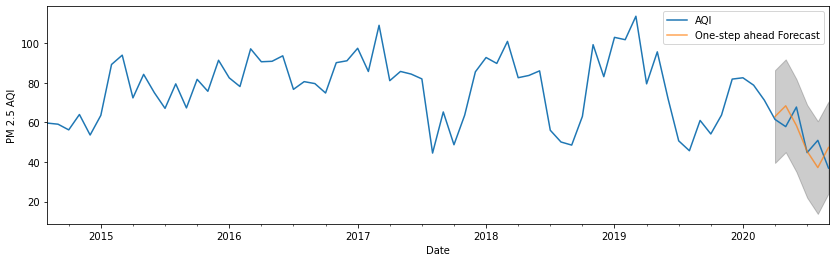

In [48]:
pred = results.get_prediction(start = pd.to_datetime('2020-04'), dynamic=False)
pred_ci = pred.conf_int()
ax = y1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM 2.5 AQI')
plt.legend()
plt.show()

In [49]:
y_forecasted = pred.predicted_mean
y_truth = y1['2020-04':]
mse = ((y_forecasted - y_truth.AQI) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 83.24
The Root Mean Squared Error is 9.12


> 2020년 이전의 미세먼지 데이터를 보면 봄에 미세먼지가 높게 나타난다. 하지만 실제로는 예측과는 다르게 미세먼지가 감소한 경향을 보인다. 이는 코로나 바이러스 때문에 중국의 공장이 가동을 하지 않아 미세먼지가 준 것으로 보인다.

### PM 10 분석

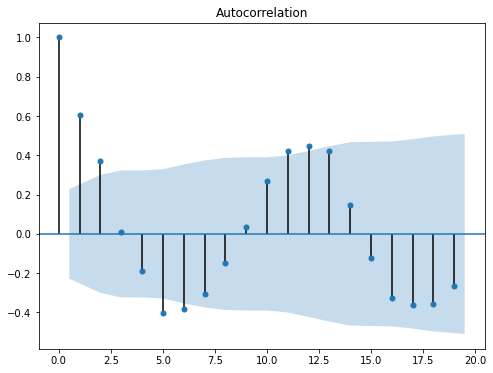

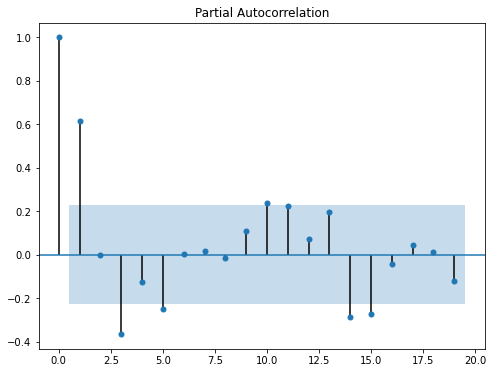

In [52]:
# acf
rcParams['figure.figsize'] = 8, 6
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_acf(y2)
fig = plot_pacf(y2)

In [53]:
# adfuller test - 단위근검정
result = sm.tsa.stattools.adfuller(y2, maxlag = 1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#p-value = 0.003341 으로 귀무가설을 기각한다!

ADF Statistic: -3.760294
p-value: 0.003341
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588


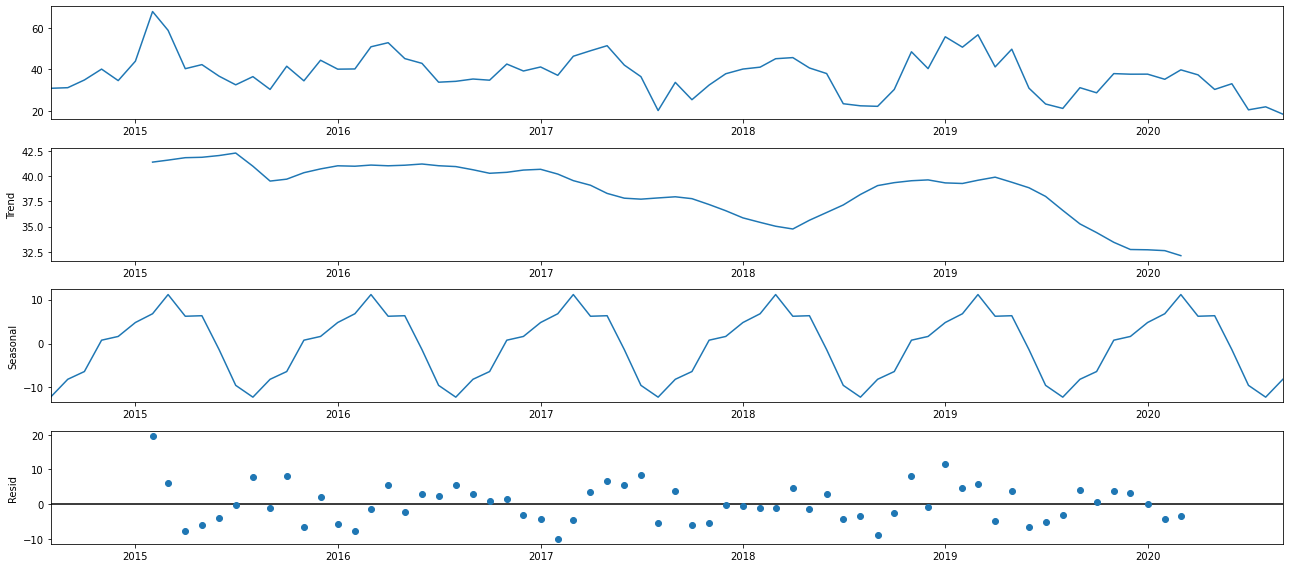

In [54]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y2, model='additive')
fig = decomposition.plot()
plt.show()

In [55]:
aic_result2=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            aic_result2.append(results.aic)
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:744.7789662160592
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:570.5127530741923
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:442.0332881598379
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:341.6742809511077
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:444.06584438973016
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.4191954648141
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:348.07633092047416
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:340.965548649109
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:665.9353074347545
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:527.7596093819
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:435.85086053211324
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:333.026874836292
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:444.42246986502215
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:414.8236485505991
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:344.8886028633227
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:332.0929993655915
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:510.382549698852
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:419.77794109815073
ARIMA(0, 1,

In [56]:
min(aic_result2)

313.7481035873716

In [57]:
#최적의 값으로 fitting: ARIMA(1, 1, 1)x(1, 1, 1, 12)12

mod = sm.tsa.statespace.SARIMAX(y2,  
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8411      0.078    -10.720      0.000      -0.995      -0.687
ma.L1          0.4488      0.186      2.418      0.016       0.085       0.813
ar.S.L12      -0.2223      0.129     -1.728      0.084      -0.475       0.030
ma.S.L12      -0.9999   1461.924     -0.001      0.999   -2866.318    2864.318
sigma2        25.1677   3.68e+04      0.001      0.999   -7.21e+04    7.21e+04


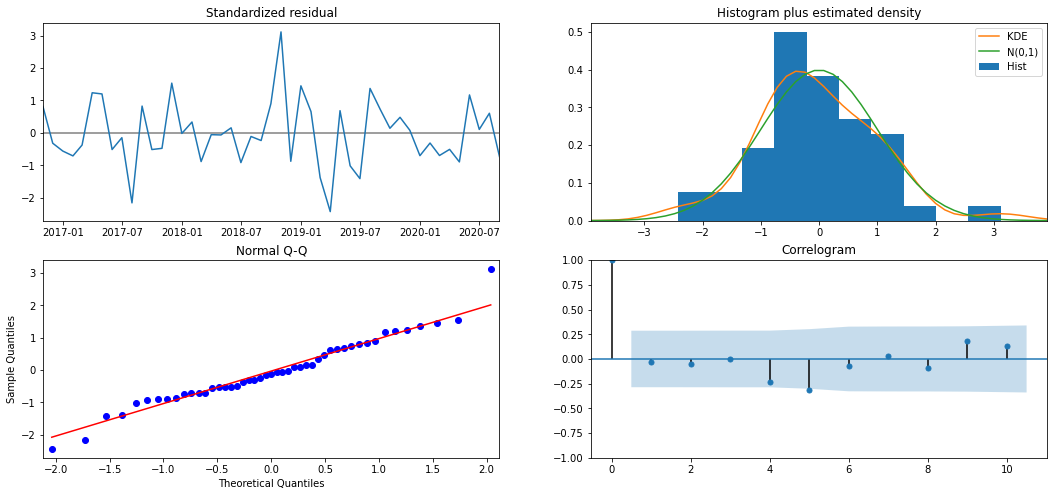

In [58]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

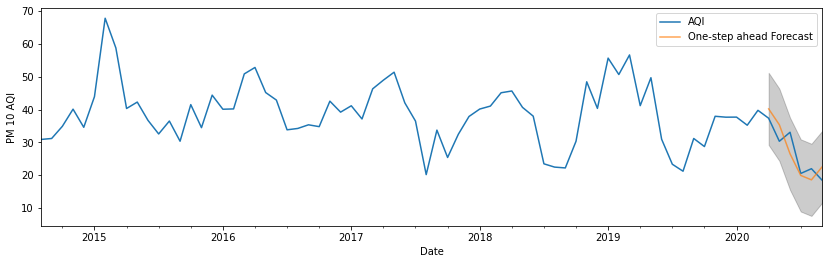

In [59]:
pred = results.get_prediction(start = pd.to_datetime('2020-04'), dynamic=False)
pred_ci = pred.conf_int()
ax = y2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM 10 AQI')
plt.legend()
plt.show()

In [60]:
y_forecasted = pred.predicted_mean
y_truth = y2['2020-04':]
mse = ((y_forecasted - y_truth.AQI) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 17.51
The Root Mean Squared Error is 4.18


> PM 2.5와 비슷하게 설명할 수 있다.